# Model Comparison and Calibration Assessment
## User Guide for Consistent Scoring Functions in Machine Learning and Actuarial Practice
**Tobias Fissler, Christian Lorentzen, Michael Mayer**

**2023-07-28**

## 1. Introduction

This notebook accompanies the user guide ["Model Comparison and Calibration Assessment"](https://arxiv.org/abs/2202.12780) on [arXiv](https://arxiv.org).
The code is similar to the one used in the user guide. Please refer to it for explanations.
Note that the results might vary depending on the Python package versions.

## 2. Regression example

The regression example is based on the "Workers Compensation" claims dataset on [OpenML](https://www.openml.org/d/42876).
We will model the ultimate claim amount of claims based on their initial case reserves and other claim features.

### 2.1 Attach all packages and fetch data

The dataset is being downloaded and then stored on disk for reuse.

In [1]:
from importlib.metadata import version
import sys

print(f"Python version {sys.version[0:6]}")
print("\nPackage versions:")
for lib in [
    "matplotlib",
    "model_diagnostics",
    "numpy",
    "pandas",
    "polars",
    "seaborn",
    "scikit-learn",
    "xgboost",
]:
    print(lib + " " + version(lib))

Python version 3.9.16

Package versions:
matplotlib 3.8.2
model_diagnostics 1.0.3
numpy 1.26.1
pandas 2.1.2
polars 0.19.7
seaborn 0.13.0
scikit-learn 1.3.2
xgboost 2.0.3


In [2]:
import calendar
from copy import deepcopy
import itertools

from fastprogress.fastprogress import progress_bar
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from model_diagnostics.calibration import compute_bias
from model_diagnostics.calibration import identification_function
from model_diagnostics.calibration import plot_bias
from model_diagnostics.calibration import plot_reliability_diagram
from model_diagnostics.scoring import GammaDeviance, decompose
from model_diagnostics.scoring import plot_murphy_diagram
import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as cs
import seaborn as sns
from sklearn import set_config
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.datasets import fetch_openml
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import xgboost


set_config(transform_output="pandas")  # needs scikit-learn >= 1.2.0

# Workers Compensation dataset, see # https://www.openml.org/d/42876
df_original = fetch_openml(data_id=42876, parser="auto").frame
# df_original is a pandas.DataFrame

### 2.2 Data preparation

In [3]:
# Note: WeekDayOfAccident: 1 means Monday
# Note: We filter out rows with WeeklyPay < 200
df = df_original.query("WeeklyPay >= 200 and HoursWorkedPerWeek >= 20")
df = df.assign(
    DateTimeOfAccident=lambda x: pd.to_datetime(x["DateTimeOfAccident"]),
    DateOfAccident=lambda x: x.DateTimeOfAccident.dt.date,
    DateReported=lambda x: pd.to_datetime(x.DateReported).dt.date,
    LogDelay=lambda x: np.log1p(pd.to_timedelta(x.DateReported - x.DateOfAccident).dt.days),
    HourOfAccident=lambda x: x.DateTimeOfAccident.dt.hour,
    WeekDayOfAccident=lambda x: pd.Categorical.from_codes(
        codes=x.DateTimeOfAccident.dt.weekday,
        # categories=list(calendar.day_abbr),
        # Easeir for plotting
        categories=list(range(1, 8)),
        ordered=True,
    ),
    LogWeeklyPay=lambda x: np.log1p(x.WeeklyPay),
    LogInitial=lambda x: np.log(x.InitialCaseEstimate),
    DependentChildren=lambda x: np.fmin(4, x.DependentChildren),
    HoursWorkedPerWeek=lambda x: np.fmin(60, x.HoursWorkedPerWeek),
    Gender=lambda x: x.Gender.astype("category"),
    MaritalStatus=lambda x: x.MaritalStatus.astype("category"),
    PartTimeFullTime=lambda x: x.PartTimeFullTime.astype("category"),
).rename(columns={"HoursWorkedPerWeek": "HoursPerWeek"})

x_continuous = [
    "Age",
    "LogWeeklyPay",
    "LogInitial",
    "HourOfAccident",
    "HoursPerWeek",
    "LogDelay",
]
x_discrete = [
    "Gender",
    "MaritalStatus",
    "PartTimeFullTime",
    "DependentChildren",
    "DaysWorkedPerWeek",
    "WeekDayOfAccident",
]
x_vars = x_continuous + x_discrete
y_var = "UltimateIncurredClaimCost"

df = df.loc[:, [y_var] + x_vars]

print(f"The prepared dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
with pd.option_context("max_colwidth", 10):
    # Pandas does not truncate column names, so we do it ourselves.
    display(df.head(10).rename(columns=lambda x: x[:10]))

The prepared dataset contains 82017 rows and 13 columns.


,UltimateIn,Age,LogWeeklyP,LogInitial,HourOfAcci,HoursPerWe,LogDelay,Gender,MaritalSta,PartTimeFu,DependentC,DaysWorked,WeekDayOfA
0,102.39,45,6.216606,9.159047,9,38,2.484907,M,S,F,0,5,4
1,1451.00,40,5.648974,8.006368,15,38,2.995732,M,M,F,0,5,3
5,320.28,50,6.249975,6.907755,7,38,3.688879,F,S,F,0,5,4
7,108.00,19,5.303305,4.700480,14,38,2.944439,M,S,F,0,5,4
8,7110.90,19,6.643790,9.179881,14,40,3.218876,M,S,F,0,5,5
9,8378.81,21,5.303305,9.159047,12,37,4.189655,F,S,F,0,5,3
10,25337.84,50,6.788972,11.156251,0,38,3.044522,M,M,F,0,5,2
11,354.00,25,5.828946,7.696213,8,35,3.258097,M,M,F,2,5,5
12,2268.75,20,5.505332,8.006368,11,40,2.397895,M,U,F,0,5,5
14,129366.81,43,7.554335,9.159047,16,40,3.044522,M,M,F,0,5,4


### 2.3 Exploratory data analysis
#### 2.3.1 Univariate description of target

Text(0.5, 1.0, 'Histogram of UltimateIncurredClaimCost')

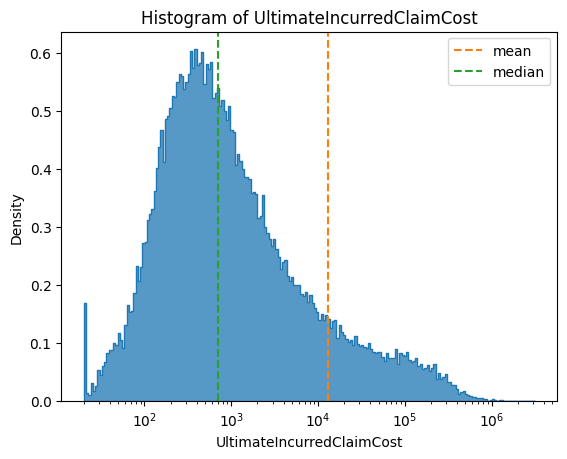

In [4]:
ax = sns.histplot(
    data=df, x=y_var, bins=200, log_scale=True, stat="density", element="step",
)
for i, (name, fun) in enumerate([("mean", np.mean), ("median", np.median)]):
    ax.axvline(
        x=fun(df[y_var]), ymin=0, ymax=1,
        color=f"C{i+1}", linestyle="--", label=name,
    )
ax.legend()
ax.set_title("Histogram of UltimateIncurredClaimCost")

#### 2.3.2 Univariate description

Text(0.5, 0.98, 'Histograms of numerical features')

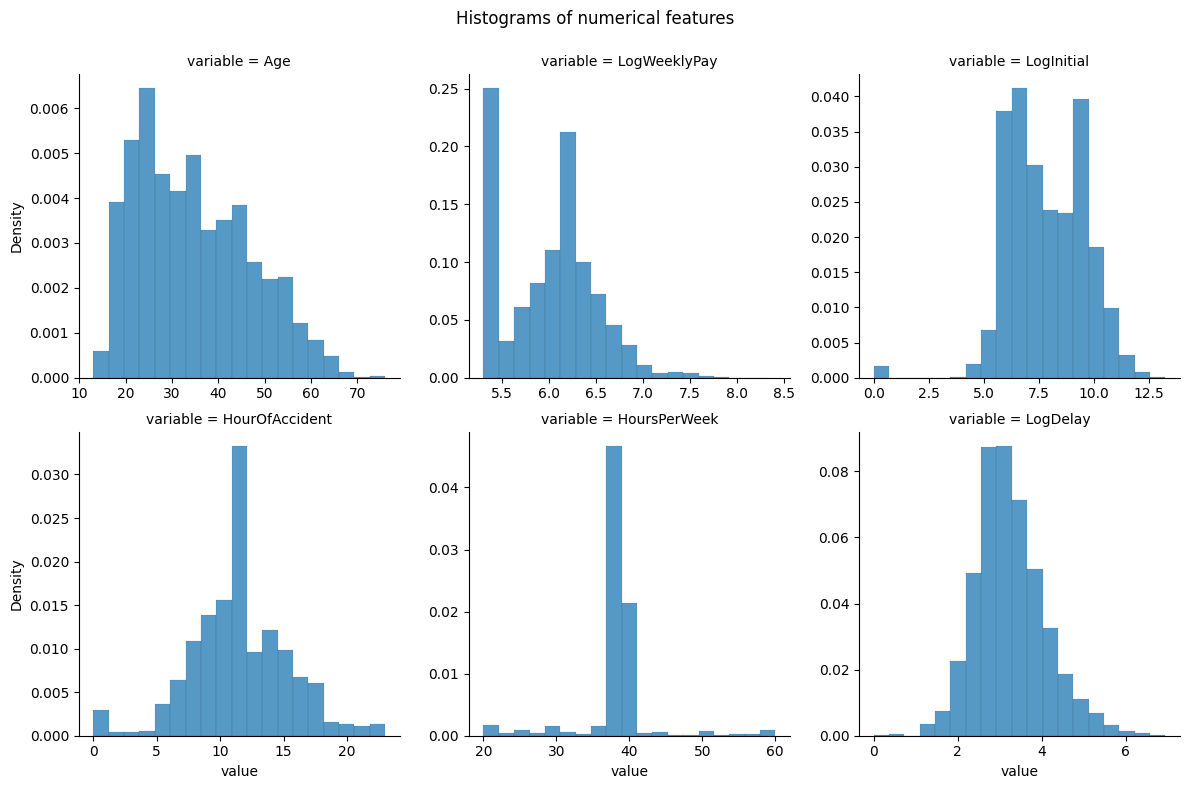

In [5]:
g = sns.displot(
    pd.melt(df.loc[:, x_continuous]),
    x="value", col="variable", stat="density",
    bins=19, common_bins=False, col_wrap=3,
    height=4,
    facet_kws={'sharex': False, 'sharey': False},
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Histograms of numerical features")

Text(0.5, 0.98, 'Histograms of categorical features')

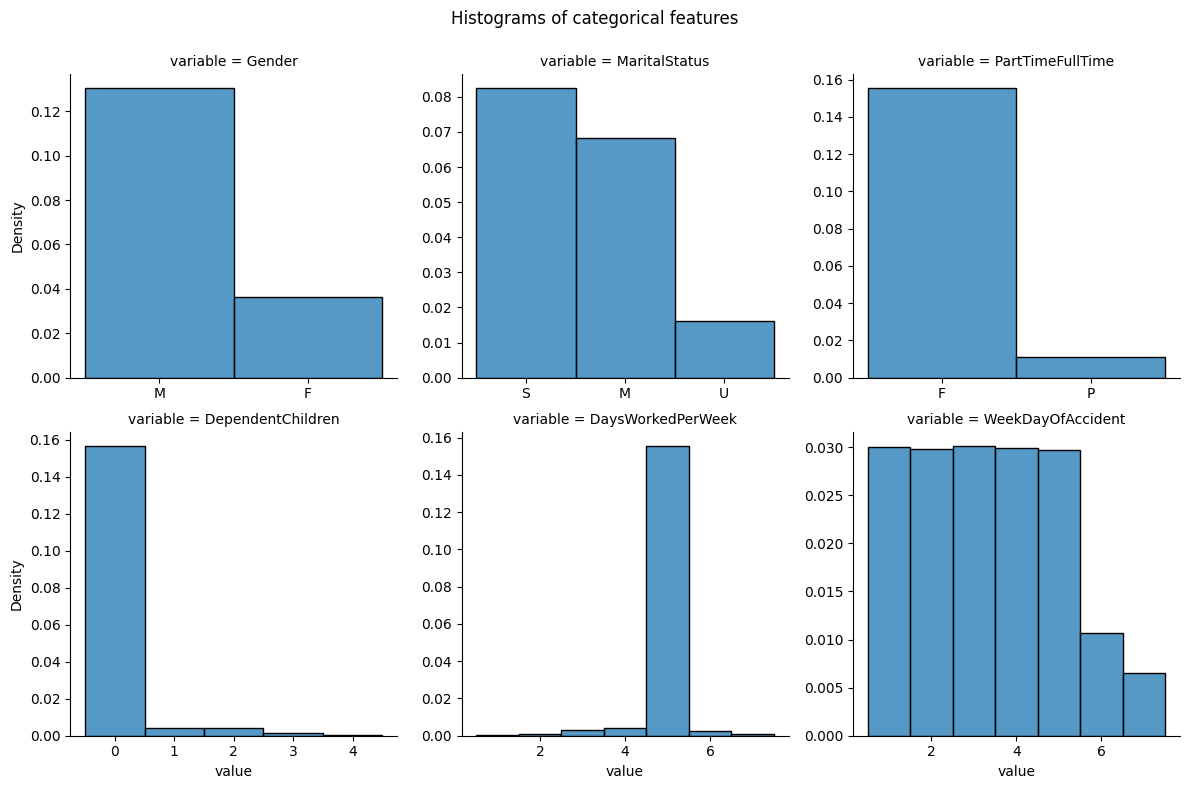

In [6]:
g = sns.displot(
    pd.melt(df.loc[:, x_discrete]),
    x="value", col="variable", stat="density",
    bins=19, common_bins=False, col_wrap=3,
    height=4,
    facet_kws={'sharex': False, 'sharey': False},
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Histograms of categorical features")

#### 2.3.3 Correlations across continuous covariates

<Axes: >

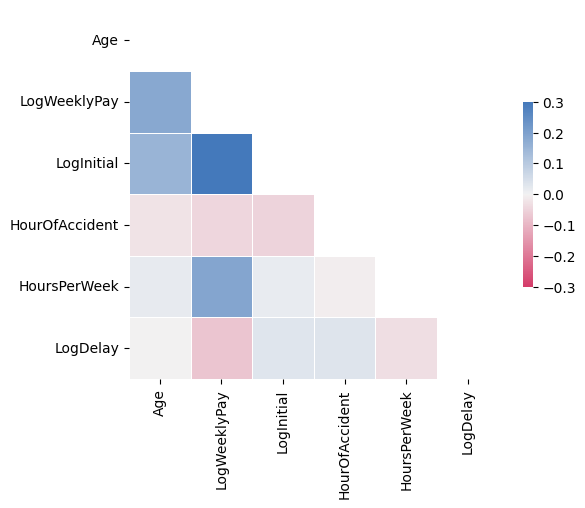

In [7]:
corr = df.loc[:, x_continuous].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
    corr, mask=mask, vmin=-0.3, vmax=0.3, center=0,
    cmap=sns.diverging_palette(360, 250, as_cmap=True),
    square=True, linewidths=.5, cbar_kws={"shrink": .5},
)

#### 2.3.4 Response in dependence of covariates

Text(0.5, 0.98, 'Boxplots for categorical features')

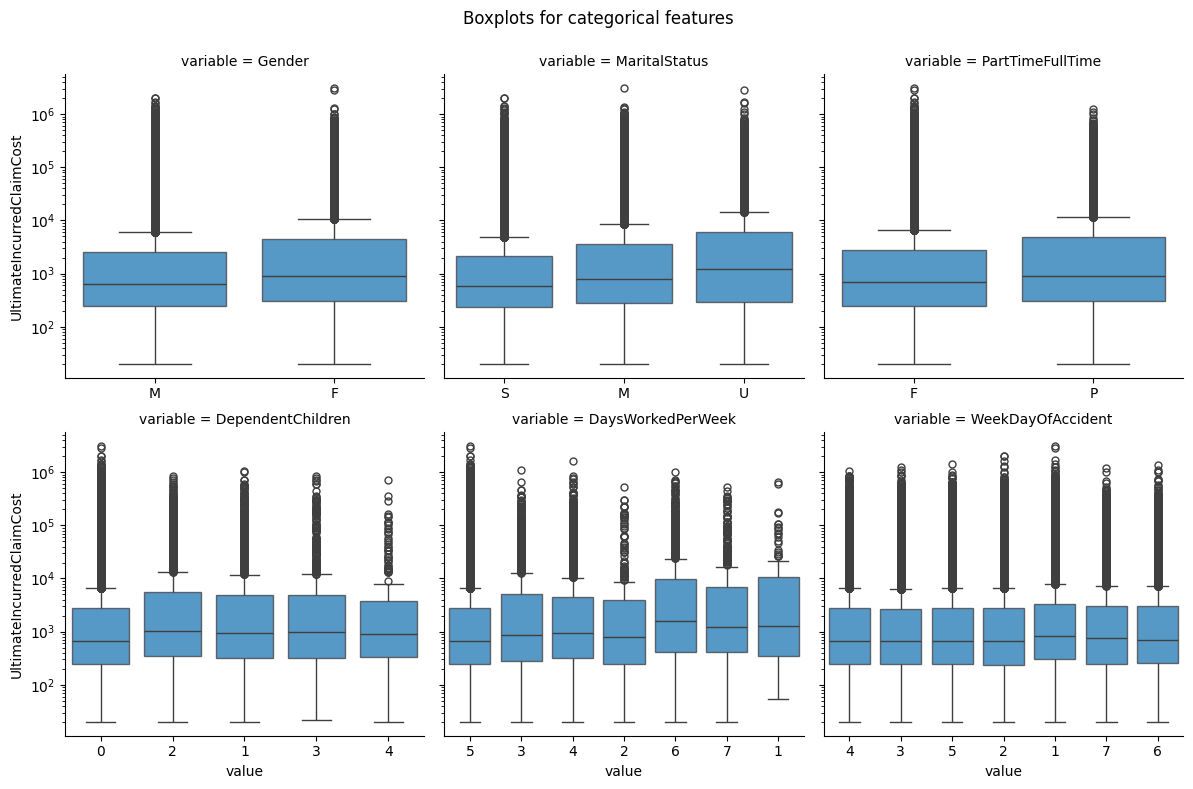

In [8]:
g = sns.catplot(
    data=pd.melt(df.loc[:, x_discrete + [y_var]], id_vars=y_var),
    x="value", y=y_var, col="variable", col_wrap=3,
    kind="box", sharex=False, height=4,
    color="C0", saturation=1, boxprops=dict(alpha=.75),
)
g.set(yscale="log")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Boxplots for categorical features")

Text(0.5, 0.98, 'Heatmaps for numerical features')

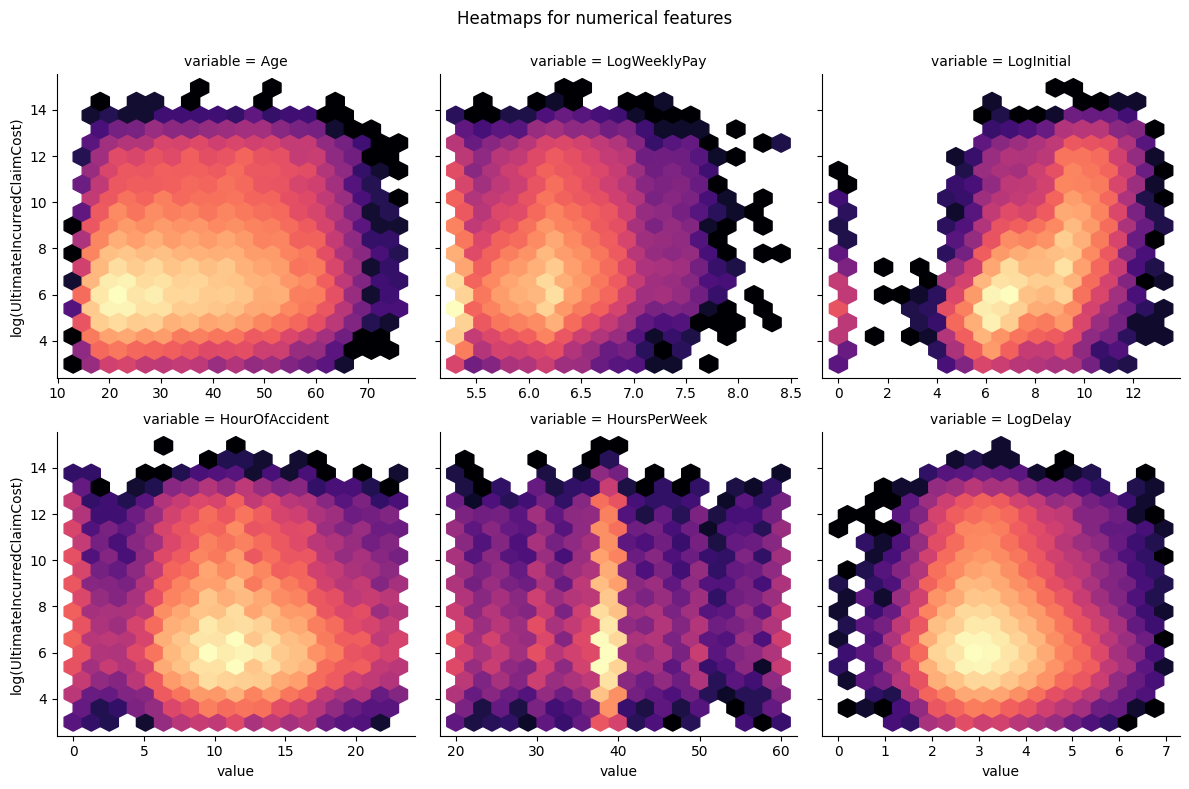

In [9]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.color_palette("magma", as_cmap=True, )#sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=18, cmap=cmap, norm=LogNorm(), **kwargs)

#g = sns.FacetGrid(tips, hue="time", col="time", height=4)
#g.map(hexbin, "total_bill", "tip", extent=[0, 50, 0, 10]);
g = sns.FacetGrid(
    data=pd.melt(df.loc[:, x_continuous + [y_var]], id_vars=y_var).assign(
        **{"log(UltimateIncurredClaimCost)": lambda x: np.log(x[y_var])}
    ),
    col="variable", col_wrap=3, height=4, sharex=False,
)
g.map(hexbin, "value", "log(UltimateIncurredClaimCost)")
#g.set(yscale="log")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Heatmaps for numerical features")

### 2.4 Data split

Next, we split our dataset into training and test data.

In [10]:
df_train, df_test = train_test_split(
    df, train_size=0.75, random_state=31415,
)
df_all = pd.concat(
    (df_train, df_test), axis=0, keys=("train", "test")
).reset_index(level=0).rename(columns={"level_0": "dataset"})

y_train, y_test = df_train[y_var], df_test[y_var]
X_train, X_test = df_train[x_vars], df_test[x_vars]

We check whether the split results in two about identically distributed samples.

In [11]:
df_all.groupby("dataset").agg(
    mean=pd.NamedAgg(column=y_var, aggfunc="mean"),
    q20=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.2)),
    q40=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.4)),
    q50=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.5)),
    q60=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.6)),
    q80=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.8)),
    q90=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.9)),
)

,mean,q20,q40,q50,q60,q80,q90
dataset,,,,,,,
test,12988.219982,200.64,452.084,685.070,1094.528,4589.792,19261.568
train,13013.751536,204.40,464.000,697.185,1109.144,4641.098,18885.178


### 2.5 The models
#### 2.5.1 Trivial Model

In [12]:
m_trivial = DummyRegressor(strategy="mean").fit(X_train, y_train)

#### 2.5.2 OLS

Here, we train an Ordinary Least Squares (OLS) model, but on the log transformed target.
`TransformedTargetRegressor` takes care of this transformation and also of the back transformation such that predictions are on the original target UltimateIncurredClaimCost.

In [13]:
# ColumnTransformer for linear models
col_trans_linear = ColumnTransformer(
    [
        ("numeric_features", "passthrough", x_continuous),
        ("categorical_features", OneHotEncoder(drop="first", sparse_output=False), x_discrete),
    ]
)

m_ols = Pipeline(
    [
        ("column_transformer", col_trans_linear),
        (
            "model",
            TransformedTargetRegressor(
                regressor=LinearRegression(),
                func=np.log,
                inverse_func=np.exp,
            )
        ),
    ]
).fit(X_train, y_train)

We expect a high bias due to the transformation. We correct for this bias by a multiplicative constant such that on the training set: $\sum_i m(x_i) = \sum_i y_i$.

In [14]:
ols_corr_factor = np.sum(y_train) / np.sum(m_ols.predict(X_train))
print(f"The correction factor is {ols_corr_factor}")

m_ols_corr = deepcopy(m_ols)
m_ols_corr[-1].regressor_.intercept_ += np.log(ols_corr_factor)

The correction factor is 6.624746167832584


In [15]:
np.sum(y_train) / np.sum(m_ols_corr.predict(X_train))

0.9999999999999997

#### 2.5.3 Gamma GLM

In [16]:
m_glm_gamma = Pipeline(
    [
        ("column_transformer", col_trans_linear),
        ("model", GammaRegressor(alpha=1e-15, solver="newton-cholesky")),
    ]
).fit(X_train, y_train)

As the Gamma GLM with log-link does not have a canonical loss-link combination, it does not fulfil the balance property and is likely biased.
Therefore, we perform the same bias correction as with OLS model.

In [17]:
glm_gamma_corr_factor = np.sum(y_train) / np.sum(m_glm_gamma.predict(X_train))
print(f"The correction factor is {glm_gamma_corr_factor}")

m_glm_gamma_corr = deepcopy(m_glm_gamma)
m_glm_gamma_corr[-1].intercept_ += np.log(glm_gamma_corr_factor)

print("Check for balance property (should be close to 1): "
      f"{np.sum(y_train) / np.sum(m_glm_gamma_corr.predict(X_train))}")

The correction factor is 1.1130770461759636
Check for balance property (should be close to 1): 1.0000000000000009


#### 2.5.4 Poisson GLM
Note that the Poisson GLM has a canonical loss-link combination that ensures good calibration (given the design matrix is well specified).

In [18]:
m_glm_poisson = Pipeline(
    [
        ("column_transformer", col_trans_linear),
        ("model", PoissonRegressor(alpha=1e-15, solver="newton-cholesky")),
    ]
).fit(X_train, y_train)

#### 2.5.5 Gradient boosted trees
Resonable choices for XGBoost's hyperparameters are provided in the grid search table stored as "grid/grid_xgb_py.csv".
Thus, there is no need for retuning those parameters.

In [19]:
%%time

# Data interface
dtrain = xgboost.DMatrix(
    data=X_train,
    label=y_train,
    enable_categorical=True,
)

# Settings
tune = False  # If set to True, it may take ~1h.
file_grid = "grid/grid_xgb_py.csv"

if tune:
    # Step 1: find good learning rate
    xgboost.cv(
        params=dict(
            learning_rate=0.03,
            tree_method="hist",
            objective="reg:gamma",
        ),
        dtrain=dtrain,
        num_boost_round=5000,
        nfold=5,
        show_stdv=False,
        early_stopping_rounds=20,
        verbose_eval=2,
    )

    # Step 2: Grid search CV on typical parameter combos
    paramGrid = dict(
        iteration=[np.nan],
        score=[np.nan],
        learning_rate=[0.03],
        max_depth=range(4, 7),
        min_child_weight=[0, 1e-04],
        colsample_bynode=[0.8, 1],
        subsample=[0.8, 1],
        reg_lambda=range(0, 3),
        reg_alpha=range(0, 3),
        objective=["reg:gamma"],
        tree_method=["hist"],
        eval_metric=["gamma-nloglik"],
    )
    paramGrid = pd.DataFrame.from_records(
        itertools.product(*paramGrid.values()),
        columns=paramGrid.keys(),
    )
    for i in progress_bar(range(paramGrid.shape[0])):
        cvm = xgboost.cv(
            paramGrid.iloc[i, 2:].to_dict(),
            dtrain,
            num_boost_round = 5000,
            nfold = 5,
            show_stdv = False,
            early_stopping_rounds = 20,
            seed=0,
            verbose_eval = 0,
        ) 
        paramGrid.iloc[i, 0] = (bi := cvm["test-gamma-nloglik-mean"].argmin()) + 1
        paramGrid.iloc[i, 1] = cvm.loc[bi, "test-gamma-nloglik-mean"]
    paramGrid.sort_values("score", ascending=True).to_csv(file_grid, index=False)
paramGrid = pd.read_csv(file_grid)

CPU times: user 151 ms, sys: 35.8 ms, total: 187 ms
Wall time: 27.3 ms


In [20]:
paramGrid.iloc[0]

iteration                   394.0
score                    9.736303
learning_rate                0.03
max_depth                       4
min_child_weight           0.0001
colsample_bynode              0.8
subsample                     1.0
reg_lambda                      2
reg_alpha                       2
objective               reg:gamma
tree_method                  hist
eval_metric         gamma-nloglik
Name: 0, dtype: object

In [21]:
# Step 3: Fit on best params
m_xgb = xgboost.train(
    params=paramGrid.iloc[0, 2:].to_dict() | {"seed": 31415},
    dtrain=dtrain,
    num_boost_round=int(paramGrid.iloc[0, 0]),
)

# Predict wrapper for xgb model
def m_xgb_predict(X):
    dmat = xgboost.DMatrix(X, enable_categorical=True)
    return m_xgb.predict(dmat)

# Same with bias correction
corr_fact_xgb = np.mean(y_train) / np.mean(m_xgb_predict(X_train))

def m_xgb_corr_predict(X):
    return corr_fact_xgb * m_xgb_predict(X)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

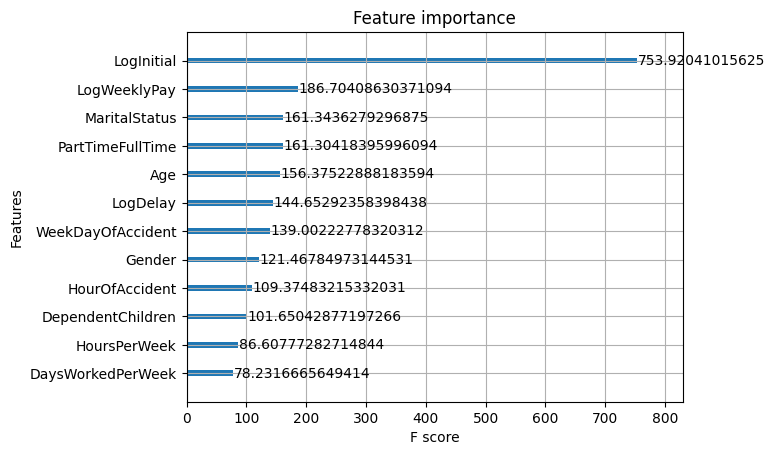

In [22]:
# feature importance, helps to select features for calibration analysis
xgboost.plot_importance(m_xgb, importance_type="gain")

### 2.6 Calibration assessment
#### 2.6.1 Unconditional calibration in terms of bias

In [23]:
model_levels = [
    "trivial", "ols", "ols_corr", "glm_gamma",
    "glm_gamma_corr", "glm_poisson", "xgb", "xgb_corr",
]

df_cali = df_all.copy()
df_cali["prediction_trivial"] = m_trivial.predict(df_all[x_vars])
df_cali["prediction_ols"] = m_ols.predict(df_all[x_vars])
df_cali["prediction_ols_corr"] = m_ols_corr.predict(df_all[x_vars])
df_cali["prediction_glm_gamma"] = m_glm_gamma.predict(df_all[x_vars])
df_cali["prediction_glm_gamma_corr"] = m_glm_gamma_corr.predict(df_all[x_vars])
df_cali["prediction_glm_poisson"] = m_glm_poisson.predict(df_all[x_vars])
df_cali["prediction_xgb"] = m_xgb_predict(df_all[x_vars])
df_cali["prediction_xgb_corr"] = m_xgb_corr_predict(df_all[x_vars])

In [24]:
# Unconditional calibration
compute_bias(
    y_obs=df_cali[y_var],
    y_pred=df_cali.loc[:, df_cali.columns.str.startswith("prediction_")],
    feature=df_cali["dataset"],
).with_columns(pl.col("model").str.extract("_(\w+)", 1))

model,dataset,bias_mean,bias_count,bias_weights,bias_stderr,p_value
str,str,f64,u32,f64,f64,f64
"""trivial""","""test""",25.531554,20505,20505.0,376.582193,0.945947
"""trivial""","""train""",-7.8360e-11,61512,61512.0,229.859381,1.0
"""ols""","""test""",-11024.114099,20505,20505.0,370.667261,2.4482e-190
"""ols""","""train""",-11049.336416,61512,61512.0,226.814431,0.0
"""ols_corr""","""test""",23.482945,20505,20505.0,354.684569,0.947213
"""ols_corr""","""train""",3.9443e-12,61512,61512.0,218.978845,1.0
"""glm_gamma""","""test""",-1250.257224,20505,20505.0,357.704339,0.000475
"""glm_gamma""","""train""",-1322.061746,61512,61512.0,220.049248,1.8885e-9
"""glm_gamma_corr…","""test""",77.036933,20505,20505.0,357.703452,0.829485


#### 2.6.2 Auto-calibration

Visualized differently on train and test.

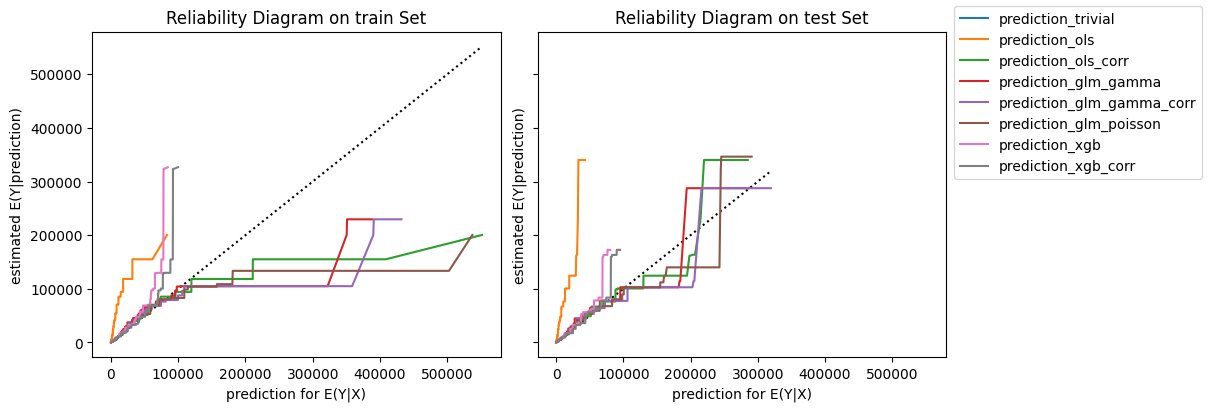

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(8 + 4, 4), layout="constrained", sharey=True, sharex=True)
for i, dataset in enumerate(["train", "test"]):
    plot_reliability_diagram(
        y_obs=df_cali.query(f"dataset=='{dataset}'")[y_var],
        y_pred=df_cali.query(f"dataset=='{dataset}'").loc[:, df_cali.columns.str.startswith("prediction_")],
        ax=axes[i]
    )
    axes[i].legend().set_visible(False)
    axes[i].set_title(f"Reliability Diagram on {dataset} Set")
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="outside right upper")

Lines below the diagonal means that the predictions are too high, values above the diagonal that predictions are too small.

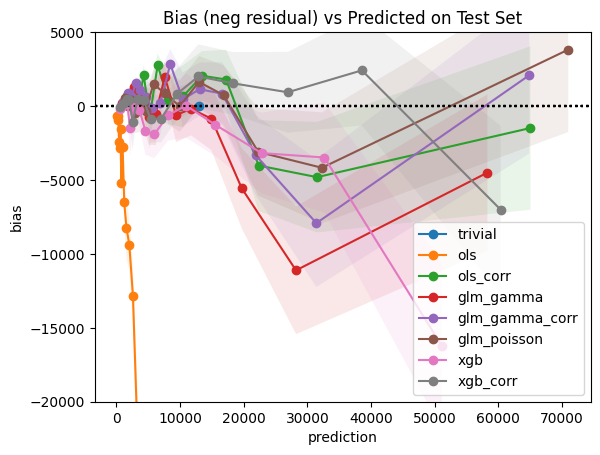

In [26]:
# We use the plot_bias function, but we must loop over it, because
# we want to set feature=y_pred which is different for every model.
fig, ax = plt.subplots()
for i, model in enumerate(model_levels):
    plot_bias(
        y_obs=df_cali.query("dataset=='test'")[y_var],
        y_pred=df_cali.query("dataset=='test'")[f"prediction_{model}"],
        feature=df_cali.query("dataset=='test'")[f"prediction_{model}"],
        n_bins=15,
        ax=ax
    )
    ax.lines[-1].set_label(model)
ax.set_xlabel("prediction")
ax.set_title("Bias (neg residual) vs Predicted on Test Set")
ax.set_ylim(-2e4, 0.5e4)
ax.legend()

In [27]:
# Table for test function phi = prediction
# First, we convert to a long table.
df_cali_long = pd.melt(
    frame=df_cali,
    id_vars=["dataset", y_var] + x_vars, 
    value_vars=["prediction_" + m for m in model_levels],
    var_name="model", 
    value_name="prediction",
)
df_cali_long["model"] = pd.Categorical(
    values=df_cali_long["model"].str.removeprefix("prediction_"),
    categories=model_levels,
)

# Test value is phi * V = y_pred * (y_pred - y_obs)
df_cali_long["bias_test"] = df_cali_long["prediction"] * identification_function(y_obs=df_cali_long[y_var], y_pred=df_cali_long["prediction"])
df_cali_long.groupby(["dataset", "model"], observed=True).agg(bias_test=("bias_test", "mean")).unstack(0)

bias_test              
dataset                 test         train
model                                     
trivial         3.322613e+05  1.558188e-08
ols            -6.331526e+07 -6.089994e+07
ols_corr       -3.654297e+06  6.592958e+06
glm_gamma      -2.916415e+07 -2.687501e+07
glm_gamma_corr  1.700539e+07  1.858736e+07
glm_poisson     3.565341e+07  4.251958e+07
xgb            -7.629522e+07 -8.622279e+07
xgb_corr       -2.164528e+07 -3.358370e+07

#### 2.6.3 Calibration conditional on Gender

In [28]:
compute_bias(
    y_obs=df_cali.query("dataset=='train'")[y_var],
    y_pred=df_cali.query("dataset=='train'")[[col for col in df_cali if col.startswith("prediction_")]],
    feature=df_cali.query("dataset=='train'")["Gender"],
)

model,Gender,bias_mean,bias_count,bias_weights,bias_stderr,p_value
str,cat,f64,u32,f64,f64,f64
"""prediction_tri…","""F""",-4318.448712,13547,13547.0,586.026761,1.8182e-13
"""prediction_tri…","""M""",1219.681532,47965,47965.0,243.641243,5.5753e-7
"""prediction_ols…","""F""",-14856.17284,13547,13547.0,579.744579,1.8171e-141
"""prediction_ols…","""M""",-9974.152156,47965,47965.0,240.186705,0.0
"""prediction_ols…","""F""",-929.147163,13547,13547.0,565.077502,0.100141
"""prediction_ols…","""M""",262.42378,47965,47965.0,231.056463,0.256064
"""prediction_glm…","""F""",-1081.846783,13547,13547.0,566.884792,0.05636
"""prediction_glm…","""M""",-1389.906885,47965,47965.0,232.385179,2.2327e-9
"""prediction_glm…","""F""",755.695186,13547,13547.0,567.864568,0.183288


In [29]:
compute_bias(
    y_obs=df_cali.query("dataset=='test'")[y_var],
    y_pred=df_cali.query("dataset=='test'")[[col for col in df_cali if col.startswith("prediction_")]],
    feature=df_cali.query("dataset=='test'")["Gender"],
)

model,Gender,bias_mean,bias_count,bias_weights,bias_stderr,p_value
str,cat,f64,u32,f64,f64,f64
"""prediction_tri…","""F""",-4575.615427,4382,4382.0,932.21244,9.5189e-7
"""prediction_tri…","""M""",1276.057266,16123,16123.0,405.885733,0.00167
"""prediction_ols…","""F""",-15068.060981,4382,4382.0,919.635048,1.3160e-58
"""prediction_ols…","""M""",-9925.027375,16123,16123.0,399.27138,6.9725e-134
"""prediction_ols…","""F""",-886.354825,4382,4382.0,891.389676,0.320107
"""prediction_ols…","""M""",270.763793,16123,16123.0,380.49584,0.476718
"""prediction_glm…","""F""",-1091.627691,4382,4382.0,898.827635,0.224622
"""prediction_glm…","""M""",-1293.370454,16123,16123.0,383.784357,0.000753
"""prediction_glm…","""F""",773.887934,4382,4382.0,901.1787,0.390525


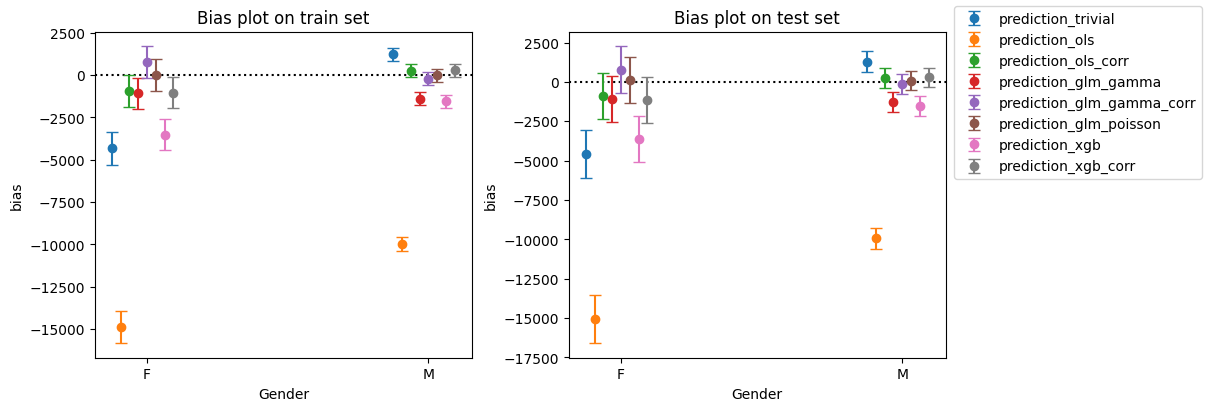

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(8+4, 4), layout="constrained")
for i, dataset in enumerate(["train", "test"]):
    plot_bias(
        y_obs=df_cali.query(f"dataset=='{dataset}'")[y_var],
        y_pred=df_cali.query(f"dataset=='{dataset}'")[[col for col in df_cali if col.startswith("prediction_")]],
        feature=df_cali.query(f"dataset=='{dataset}'")["Gender"],
        ax=axes[i]
    )
    axes[i].legend().set_visible(False)
    axes[i].set_title(f"Bias plot on {dataset} set")
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="outside right upper")

#### 2.6.4 Calibration conditional on LogWeeklyPay

LogWeeklyPay is the second most important feature after the initial claim reserve estimate.

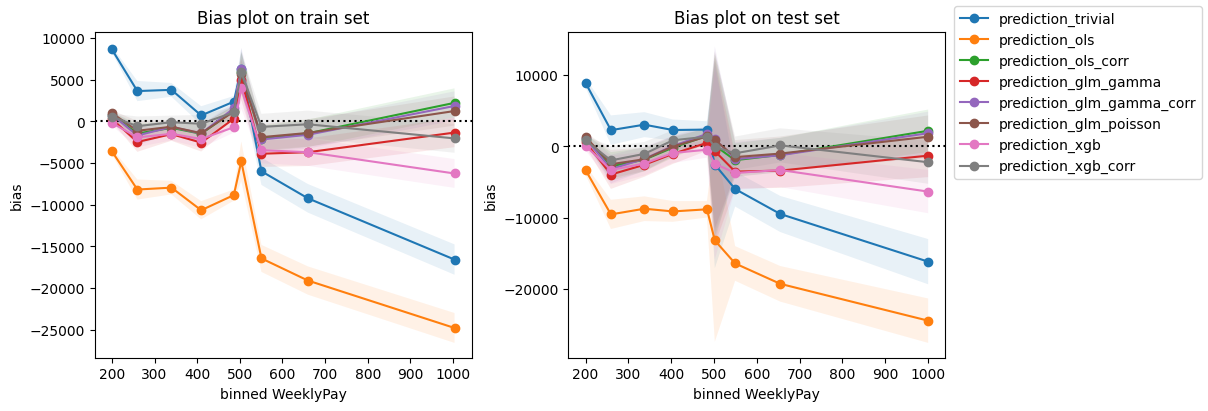

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(8+4, 4), layout="constrained")
for i, dataset in enumerate(["train", "test"]):
    plot_bias(
        y_obs=df_cali.query(f"dataset=='{dataset}'")[y_var],
        y_pred=df_cali.query(f"dataset=='{dataset}'")[[col for col in df_cali if col.startswith("prediction_")]],
        feature=pd.Series(
            data=np.exp(df_cali.query(f"dataset=='{dataset}'")["LogWeeklyPay"]) - 1,
            name="WeeklyPay",
        ),
        ax=axes[i]
    )
    axes[i].legend().set_visible(False)
    axes[i].set_title(f"Bias plot on {dataset} set")
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="outside right upper")

In [32]:
# Test function = LogWeeklyPay on test set
results = []
for i, dataset in enumerate(["train", "test"]):
    phi = df_cali.query(f"dataset=='{dataset}'")["LogWeeklyPay"]
    results.append(
        compute_bias(
            y_obs=phi * df_cali.query(f"dataset=='{dataset}'")[y_var],
            y_pred=df_cali.query(f"dataset=='{dataset}'")[
            [col for col in df_cali if col.startswith("prediction_")]
            ].multiply(phi, axis="index"),
        ).with_columns(dataset=pl.lit(dataset))
    )
with pl.Config(fmt_str_lengths=50):
    display(
        pl.concat(results)
        .select(pl.col("model", "dataset"), cs.all() -  cs.by_name("model", "dataset"))
    )

model,dataset,bias_mean,bias_count,bias_weights,bias_stderr,p_value
str,str,f64,u32,f64,f64,f64
"""prediction_trivial""","""train""",-3625.267973,61512,61512.0,1459.440315,0.012994
"""prediction_ols""","""train""",-69333.401818,61512,61512.0,1441.968457,0.0
"""prediction_ols_corr""","""train""",171.049746,61512,61512.0,1389.763778,0.902046
"""prediction_glm_gamma""","""train""",-8184.354304,61512,61512.0,1396.514731,4.6366e-9
"""prediction_glm_gamma_corr""","""train""",127.481632,61512,61512.0,1396.971548,0.92729
"""prediction_glm_poisson""","""train""",7.8609e-10,61512,61512.0,1392.008753,1.0
"""prediction_xgb""","""train""",-12717.458459,61512,61512.0,1383.309855,3.9172e-20
"""prediction_xgb_corr""","""train""",-277.01686,61512,61512.0,1379.018456,0.840793
"""prediction_trivial""","""test""",-3519.901907,20505,20505.0,2394.251593,0.141537


### 2.7 Model comparison
#### 2.7.1 Compare absolute and relative performance scores

In [33]:
results = []
for i, dataset in enumerate(["train", "test"]):
    phi = df_cali.query(f"dataset=='{dataset}'")["LogWeeklyPay"]
    results.append(
        decompose(
            y_obs=phi * df_cali.query(f"dataset=='{dataset}'")[y_var],
            y_pred=df_cali.query(f"dataset=='{dataset}'")[
            [col for col in df_cali if col.startswith("prediction_")]
            ].multiply(phi, axis="index"),
            scoring_function=GammaDeviance()
        ).with_columns(dataset=pl.lit(dataset))
    )
with pl.Config(fmt_str_lengths=50):
    display(
        df_perf:=pl.concat(results)
        .select(pl.col("model", "dataset"), cs.all() -  cs.by_name("model", "dataset"))
    )

model,dataset,miscalibration,discrimination,uncertainty,score
str,str,f64,f64,f64,f64
"""prediction_trivial""","""train""",0.368134,0.465973,5.160036,5.062198
"""prediction_ols""","""train""",7.786316,1.642042,5.160036,11.30431
"""prediction_ols_corr""","""train""",0.271904,1.642042,5.160036,3.789899
"""prediction_glm_gamma""","""train""",0.161205,1.669807,5.160036,3.651434
"""prediction_glm_gamma_corr""","""train""",0.172282,1.669807,5.160036,3.662511
"""prediction_glm_poisson""","""train""",0.383308,1.666944,5.160036,3.8764
"""prediction_xgb""","""train""",0.053292,1.970629,5.160036,3.242699
"""prediction_xgb_corr""","""train""",0.068878,1.970629,5.160036,3.258285
"""prediction_trivial""","""test""",0.395237,0.494522,5.192712,5.093427


Text(0.5, 1.0, 'Mean Gamma Deviance')

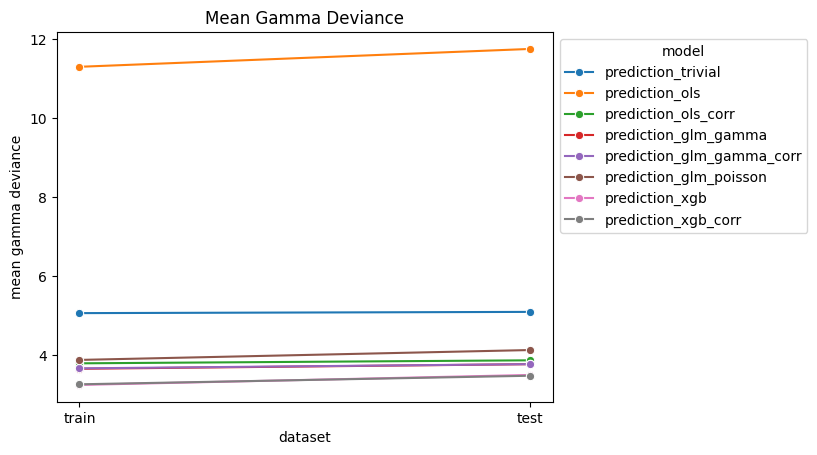

In [34]:
ax = sns.lineplot(data=df_perf, x="dataset", y="score", hue="model", marker="o")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_ylabel("mean gamma deviance")
ax.set_title("Mean Gamma Deviance")

#### 2.7.2 Murphy diagram (for elementary score)

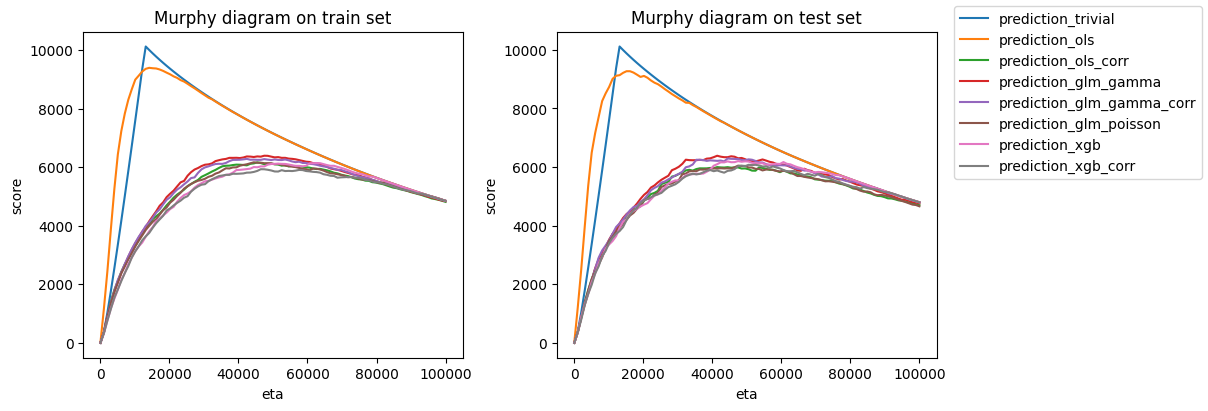

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(8+4, 4), layout="constrained")
for i, dataset in enumerate(["train", "test"]):
    plot_murphy_diagram(
        y_obs=df_cali.query(f"dataset=='{dataset}'")[y_var],
        y_pred=df_cali.query(f"dataset=='{dataset}'")[
            [col for col in df_cali if col.startswith("prediction_") and col not in {"trivial", "ols"}]
        ],
        etas=np.linspace(0, 1e5, 100),
        ax=axes[i]
    )
    axes[i].legend().set_visible(False)
    axes[i].set_title(f"Murphy diagram on {dataset} set")
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="outside right upper")